# Analysis of player transfers for the German Bundesliga 2000-2023

This project is designed to demonstrate my abilities to work with data using python.

I used scrapy to scrape all player transfers from and to Bundesliga clubs between 2000 and 2023 (relevant scrapy code can be found in transfer-spider.py and items.py). 

I then cleaned up the data: 
- deleted identical cells (transfers between two Bundesliga clubs and loans would originally appear twice in the dataset -  1257 rows/12% deleted)
- changed transfer fee to have a single format (loans to 0, unknown values to 0 (140 rows/1.5%), free move to 0 (2368 rows/25%), end of career/career-break to 0 (430 rows/5%), other values to value in million Euros) - This is not 100% accurate, but I consider it close enough, as unknown values amount to 140 rows/1.5% with a mean player value of 0.45 million Euros and loans in football usually entail comparatively low fees or none at all.
- categorised transfers (transfer type: 0 - transfer, 1 - loan, 2 - free move, 3 - end of career, 4 - free agent) 
- changed the format of player value to values in million Euros. 4705 rows/50% had player value set to '-', which makes this feature questionable to say the least. Changed '-' value to 0, as the mean transfer fee for players with this value is 0.58 million Euros and thus comparatively low.
- deleted one extreme outlier with regards to player age (one 11 year old player, all other players 16 or older)
- added player nationality for 3 players based on youth clubs
- changed player position for defence/LIB, midfield and forward to IV (centre back), ZM (central midfield), and MS (cetre forward) to reduce categories, as this only entailed 57 rows/0.5% of all players 

The cleaning process can be found in Cleaning Bundesliga Dataset.ipynb.



In [30]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv(
    r"2000-2023_transfers_bundesliga_clean.csv")

In [32]:
df.describe()

,Unnamed: 0,player_age,player_value,transfer_date,transfer_fee,transfer_type
count,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000,9242.00000
mean,5226.013309,24.703527,2.021384,2012.296473,1.251105,1.04934
std,3042.369589,4.290724,7.189704,6.615441,4.767879,0.92023
min,0.000000,16.000000,0.000000,2000.000000,0.000000,0.00000
25%,2571.500000,21.000000,0.000000,2007.000000,0.000000,0.00000
50%,5242.500000,24.000000,0.000000,2013.000000,0.000000,1.00000
75%,7839.750000,27.000000,0.900000,2018.000000,0.250000,2.00000
max,10500.000000,41.000000,170.000000,2023.000000,140.000000,4.00000


## Drop unnecessary duplicate of index column 'Unnamed: 0'

In [33]:
df = df.drop("Unnamed: 0", axis=1)

In [34]:
df.describe()

,player_age,player_value,transfer_date,transfer_fee,transfer_type
count,9242.000000,9242.000000,9242.000000,9242.000000,9242.00000
mean,24.703527,2.021384,2012.296473,1.251105,1.04934
std,4.290724,7.189704,6.615441,4.767879,0.92023
min,16.000000,0.000000,2000.000000,0.000000,0.00000
25%,21.000000,0.000000,2007.000000,0.000000,0.00000
50%,24.000000,0.000000,2013.000000,0.000000,1.00000
75%,27.000000,0.900000,2018.000000,0.250000,2.00000
max,41.000000,170.000000,2023.000000,140.000000,4.00000


## Mean transfer fee for players of value 0 is ca. 580000 Euros

In [35]:
df.loc[df.player_value == 0, "transfer_fee"].mean()

0.5811588010204086

## Drop values for 2023 as these would potentially skew the results, since the summer transfer window 2023 is not open yet, so only very few transfers are already finalised

In [36]:
df = df.drop(df.loc[df.transfer_date == 2023].index)

In [37]:
df.describe()

,player_age,player_value,transfer_date,transfer_fee,transfer_type
count,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000
mean,24.716250,1.984180,2012.116294,1.264860,1.049070
std,4.302176,7.194916,6.522240,4.793975,0.925249
min,16.000000,0.000000,2000.000000,0.000000,0.000000
25%,21.000000,0.000000,2007.000000,0.000000,0.000000
50%,24.000000,0.000000,2012.000000,0.000000,1.000000
75%,28.000000,0.800000,2018.000000,0.250000,2.000000
max,41.000000,170.000000,2022.000000,140.000000,4.000000


## Get an overview over the total number of each transfer type for the time period:
- regular transfers with fee (0): 2899/32%
- transfers on loan (1): 3432/38%
- free moves (2): 2363/26%
- end of career (3): 203/2%
- free agent (contract ended without move to a new club) (4): 192/2%

This amounts to a total number of permanent moves to a new club of 5262 (58%)

In [38]:
df.transfer_type.value_counts()

1.0    3432
0.0    2899
2.0    2363
3.0     203
4.0     192
Name: transfer_type, dtype: int64

In [39]:
yearly_paid_transfers = df.loc[df.transfer_type == 0].groupby(["transfer_date"])["player_name"].count()
yearly_loan_transfers = df.loc[df.transfer_type == 1].groupby(["transfer_date"])["player_name"].count()
yearly_free_transfers = df.loc[df.transfer_type == 2].groupby(["transfer_date"])["player_name"].count()

yearly_transfer_types = pd.DataFrame({"paid transfers": yearly_paid_transfers, "loans": yearly_loan_transfers, "free moves": yearly_free_transfers})

## Looking at the three major transfer types over time produces the first interesting finding in the dataset. While both free and paid transfers stay roughly constant when looking at the full timespan, the increase in loans is almost linear.

On its own, this finding is not enough to tell us anything. Other interesting aspects of the below graphs are the period between 2001 and 2005/2006 where there are contrary movements in paid and free transfers (similar between 2013 and 2019). The dip in paid transfers between 2019 and 2020 can be attributed to the Covid pandemic.

<AxesSubplot:title={'center':'Transfer Types over time'}, xlabel='Year', ylabel='Nr. of Transfers'>

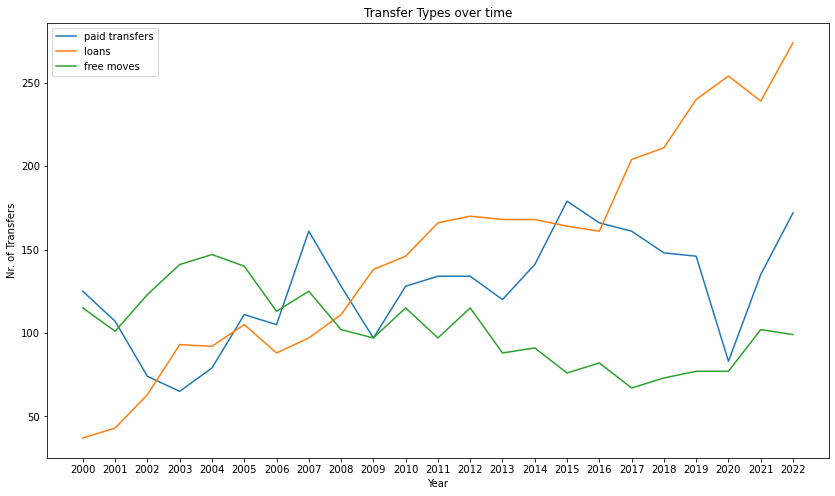

In [40]:
yearly_transfer_types.plot(y=["paid transfers", "loans", "free moves"], title="Transfer Types over time", xlabel="Year", 
                          ylabel="Nr. of Transfers", xticks=yearly_transfer_types.index, figsize=(14,8))


In [41]:
yearly_transfer_types

,paid transfers,loans,free moves
transfer_date,,,
2000,125,37,115
2001,107,43,101
2002,74,63,123
2003,65,93,141
2004,79,92,147
2005,111,105,140
2006,105,88,113
2007,161,97,125
2008,128,111,102


In [42]:
yearly_fees = df.groupby(["transfer_date"])["transfer_fee"].mean()
yearly_values = df.groupby(["transfer_date"])["player_value"].mean()

yearly_values_fees = pd.DataFrame({"yearly fees": yearly_fees, "yearly values": yearly_values})

In [43]:
yearly_values_fees

,yearly fees,yearly values
transfer_date,,
2000,0.528097,0.000000
2001,0.802921,0.000000
2002,0.437456,0.000000
2003,0.299531,0.000000
2004,0.302906,0.000221
2005,0.420581,0.003784
2006,0.632926,0.004489
2007,0.911709,0.058254
2008,0.700708,0.098611


## As we can see in the next plot, there is still a problem with our data that was not identified in the cleaning process: player values are not recorded as value at the time of the transfer, but instead as their current value, which results in average values up to 2006 being almost equal to 0. This unfortunately completely invalidates the player value data, increasingly so the more time has passed since the transfer. I will try to obtain more useful data for this in the future.

<AxesSubplot:xlabel='transfer_date'>

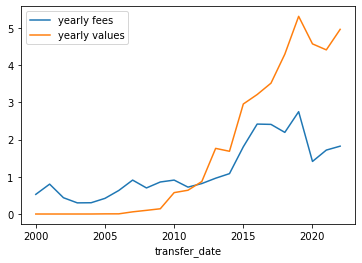

In [44]:
yearly_values_fees.plot()

## While aggregated statistics on transfers can offer some insight on the market overall, it will be more interesting to analyse incoming vs. outgoing transfers, so i modified my web scraping code to retrieve a list of the Bundesliga clubs for each year, to then match transfers to the current Bundesliga members

In [45]:
bl_clubs = pd.read_csv("bundesliga_club_list.csv")
bl_clubs.head()

,club_from,club_to,player_age,player_name,player_nationality,player_position,player_value,transfer_date,transfer_fee,transfer_type
0,NaN,FC Bayern München,NaN,NaN,NaN,NaN,NaN,2023,NaN,NaN
1,NaN,Borussia Dortmund,NaN,NaN,NaN,NaN,NaN,2023,NaN,NaN
2,NaN,Bayer 04 Leverkusen,NaN,NaN,NaN,NaN,NaN,2023,NaN,NaN
3,NaN,RasenBallsport Leipzig,NaN,NaN,NaN,NaN,NaN,2023,NaN,NaN
4,NaN,1.FC Union Berlin,NaN,NaN,NaN,NaN,NaN,2023,NaN,NaN


In [46]:
yearly_bl_clubs = bl_clubs.groupby("transfer_date")
yearly_bl_clubs.get_group(2021)['club_to']


36           FC Bayern München
37      RasenBallsport Leipzig
38           Borussia Dortmund
39               VfL Wolfsburg
40         Eintracht Frankfurt
41         Bayer 04 Leverkusen
42           1.FC Union Berlin
43    Borussia Mönchengladbach
44               VfB Stuttgart
45                 SC Freiburg
46         TSG 1899 Hoffenheim
47              1.FSV Mainz 05
48                 FC Augsburg
49                  Hertha BSC
50           Arminia Bielefeld
51                   1.FC Köln
52                  VfL Bochum
53        SpVgg Greuther Fürth
Name: club_to, dtype: object

In [47]:
yearly_transfers = df.groupby("transfer_date")
yearly_transfers.get_group(2021)

,club_from,club_to,player_age,player_name,player_nationality,player_position,player_value,transfer_date,transfer_fee,transfer_type
714,RasenBallsport Leipzig,FC Bayern München,22.0,Dayot Upamecano,Frankreich,IV,60.000,2021,42.5,0.0
715,RasenBallsport Leipzig,FC Bayern München,27.0,Marcel Sabitzer,Österreich,ZM,20.000,2021,15.0,0.0
716,Hamburger SV,FC Bayern München,32.0,Sven Ulreich,Deutschland,TW,0.900,2021,0.0,2.0
717,FC Reading,FC Bayern München,23.0,Omar Richards,England,LV,7.000,2021,0.0,2.0
718,SpVgg Greuther Fürth,FC Bayern München,22.0,Adrian Fein,Deutschland,DM,0.600,2021,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1195,SpVgg Greuther Fürth,Würzburger Kickers,20.0,Alexander Lungwitz,Deutschland,LV,0.125,2021,0.0,2.0
1196,SpVgg Greuther Fürth,NK Siroki Brijeg,23.0,Marijan Cavar,Bosnien-Herzegowina,ZM,0.400,2021,0.0,2.0
1197,SpVgg Greuther Fürth,Türkgücü München,35.0,Mergim Mavraj,Albanien,IV,0.000,2021,0.0,2.0
1198,SpVgg Greuther Fürth,SV Sandhausen,24.0,Nils Seufert,Deutschland,ZM,0.400,2021,0.0,1.0


## Player transfers from and to Bundesliga clubs have increased almost equally over the time period hinting at decreasing time players spend at one club. This is in line with, but not only due to the increase of loans.

In [48]:
incoming_transfers_list = []
for i in range(2000, 2023):
    incoming_transfers_list.append(yearly_transfers.get_group(i).loc[yearly_transfers.get_group(i)['club_to'].isin(yearly_bl_clubs.get_group(i)['club_to'])])

incoming_transfers = pd.concat(incoming_transfers_list, ignore_index=True)
incoming_transfers.describe()

    

,player_age,player_value,transfer_date,transfer_fee,transfer_type
count,4834.000000,4834.000000,4834.000000,4834.000000,4834.000000
mean,24.111502,2.440819,2012.103020,1.571713,0.805544
std,3.776360,7.964186,6.519682,4.407600,0.755860
min,16.000000,0.000000,2000.000000,0.000000,0.000000
25%,21.000000,0.000000,2007.000000,0.000000,0.000000
50%,24.000000,0.100000,2013.000000,0.000000,1.000000
75%,27.000000,1.400000,2018.000000,1.000000,1.000000
max,39.000000,170.000000,2022.000000,80.000000,2.000000


<AxesSubplot:title={'center':'Transfers to Bundesliga clubs'}, xlabel='Year', ylabel='Nr. of Transfers'>

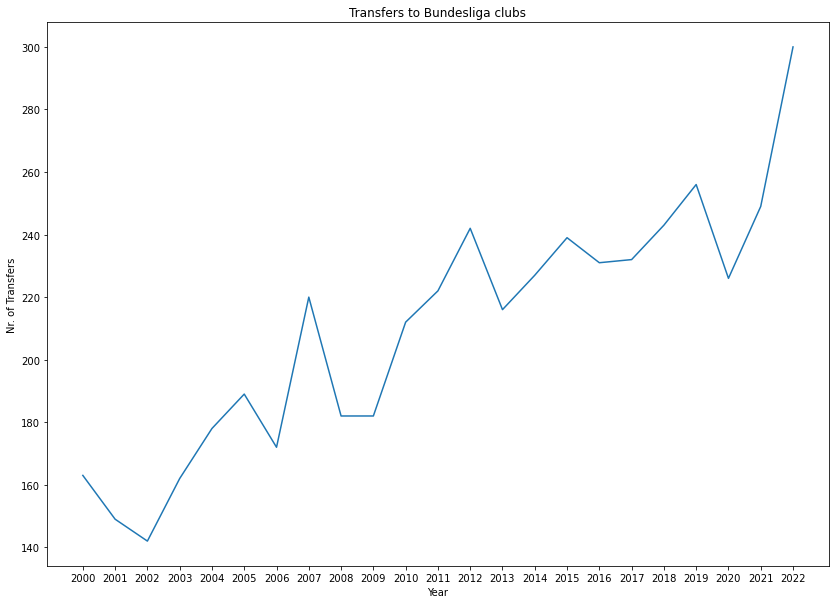

In [49]:
incoming_transfers.groupby(["transfer_date"])["player_name"].count().plot(ylabel="Nr. of Transfers", xlabel="Year", figsize=(14,10),
                                                                         xticks=yearly_transfer_types.index, 
                                                                          title="Transfers to Bundesliga clubs")

In [50]:
outgoing_transfers_list = []
for i in range(2000, 2023):
    outgoing_transfers_list.append(yearly_transfers.get_group(i).loc[yearly_transfers.get_group(i)['club_from'].isin(yearly_bl_clubs.get_group(i)['club_to'])])

outgoing_transfers = pd.concat(outgoing_transfers_list, ignore_index=True)
outgoing_transfers.describe()

,player_age,player_value,transfer_date,transfer_fee,transfer_type
count,5501.000000,5501.000000,5501.000000,5501.000000,5501.000000
mean,25.320851,1.700130,2012.090165,1.125063,1.218688
std,4.498822,6.468576,6.495835,5.070808,0.990126
min,16.000000,0.000000,2000.000000,0.000000,0.000000
25%,22.000000,0.000000,2007.000000,0.000000,0.000000
50%,25.000000,0.000000,2012.000000,0.000000,1.000000
75%,28.000000,0.700000,2018.000000,0.000000,2.000000
max,41.000000,170.000000,2022.000000,140.000000,4.000000


<AxesSubplot:title={'center':'Transfers from Bundesliga clubs'}, xlabel='Year', ylabel='Nr. of Transfers'>

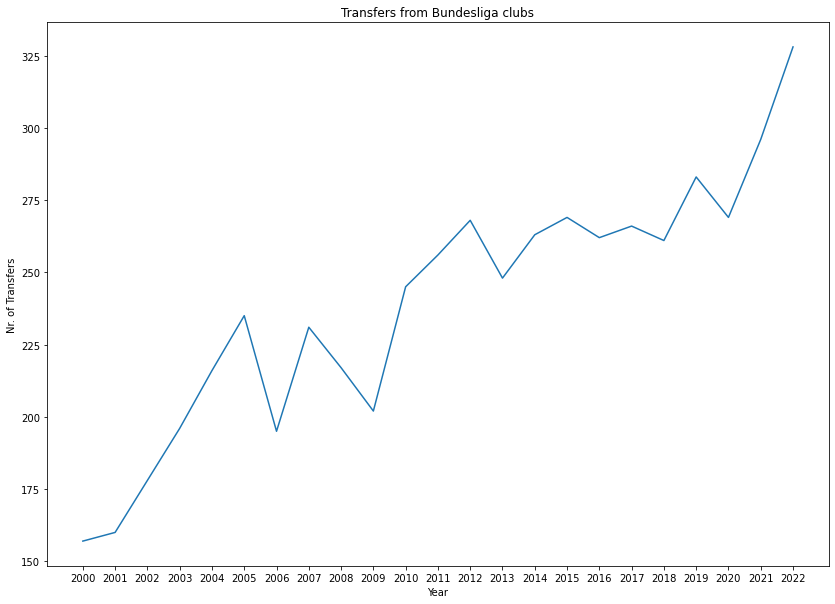

In [51]:
outgoing_transfers.groupby(["transfer_date"])["player_name"].count().plot(ylabel="Nr. of Transfers", xlabel="Year", figsize=(14,10),
                                                                         xticks=yearly_transfer_types.index, 
                                                                          title="Transfers from Bundesliga clubs")

## There are 1246 duplicate entries, meaning 1246 transfers occurred between 2 clubs that were simultaniously members of the German Bundesliga. The number of transfers between two Bundesliga clubs doubled between 2000 and 2014, dipping below that high-point afterwards.

In [52]:
intra_buli_transfers = incoming_transfers.merge(outgoing_transfers, how='inner')
intra_buli_transfers.describe()

,player_age,player_value,transfer_date,transfer_fee,transfer_type
count,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000
mean,25.039326,2.501705,2011.949438,1.838142,0.853130
std,3.548977,7.354678,6.392755,4.622570,0.786494
min,18.000000,0.000000,2000.000000,0.000000,0.000000
25%,22.000000,0.000000,2007.000000,0.000000,0.000000
50%,25.000000,0.000000,2013.000000,0.000000,1.000000
75%,28.000000,1.500000,2017.000000,1.300000,1.000000
max,39.000000,80.000000,2022.000000,43.000000,2.000000


<AxesSubplot:title={'center':'Transfers between Bundesliga clubs'}, xlabel='Year', ylabel='Nr. of Transfers'>

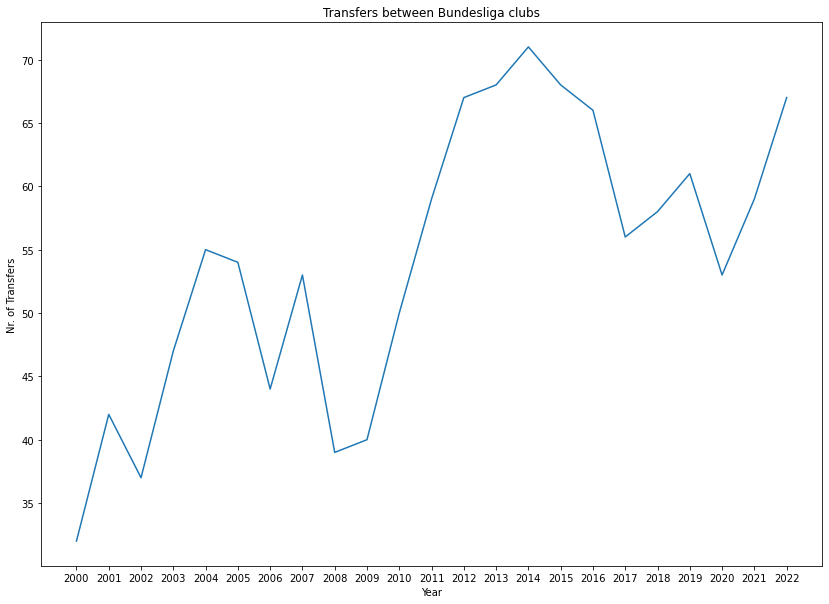

In [53]:
intra_buli_transfers.groupby(["transfer_date"])["player_name"].count().plot(ylabel="Nr. of Transfers", xlabel="Year", figsize=(14,10),
                                                                         xticks=yearly_transfer_types.index, 
                                                                          title="Transfers between Bundesliga clubs")

## Interestingly, there seems to be a slight disconnect between mean values and mean fees, starting in 2017. I would expect fees and values for transfers to become almost equal, the closer we get to the current transfer period. This could have to do with an increasing number of loans between Bundesliga clubs, where a player's value is usually far higher then the fee (I even went so far, as to use 0 as the default fee for loans). Another possible explanation for the disconnect after 2019 could be the Covid Pandemic, forcing clubs to sell players under value.

<AxesSubplot:xlabel='transfer_date'>

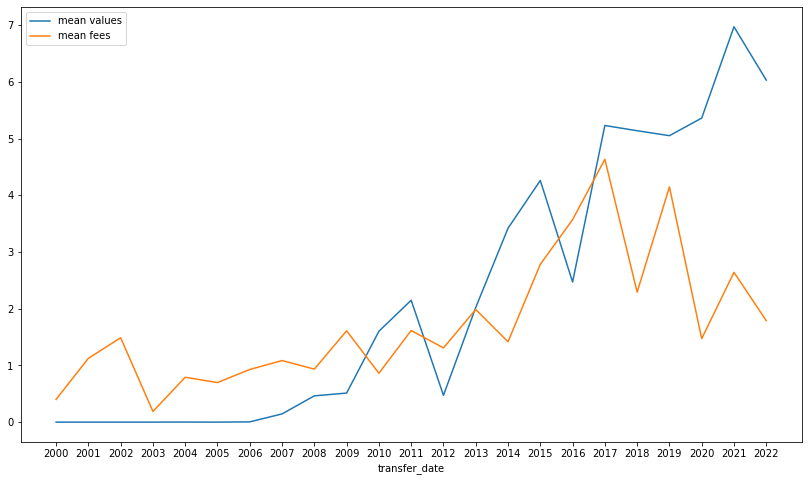

In [54]:
yearly_values = intra_buli_transfers.groupby(["transfer_date"])["player_value"].mean()
yearly_fees = intra_buli_transfers.groupby(["transfer_date"])["transfer_fee"].mean()


yearly_values_fees = pd.DataFrame({"mean values": yearly_values, "mean fees": yearly_fees})
yearly_values_fees.plot(figsize=(14,8), xticks=yearly_values_fees.index)



## As expected, there is a rather steep increase in loans between 2017 and 2018, when the disconnect between values and fees first starts to appear. 

<AxesSubplot:xlabel='transfer_date'>

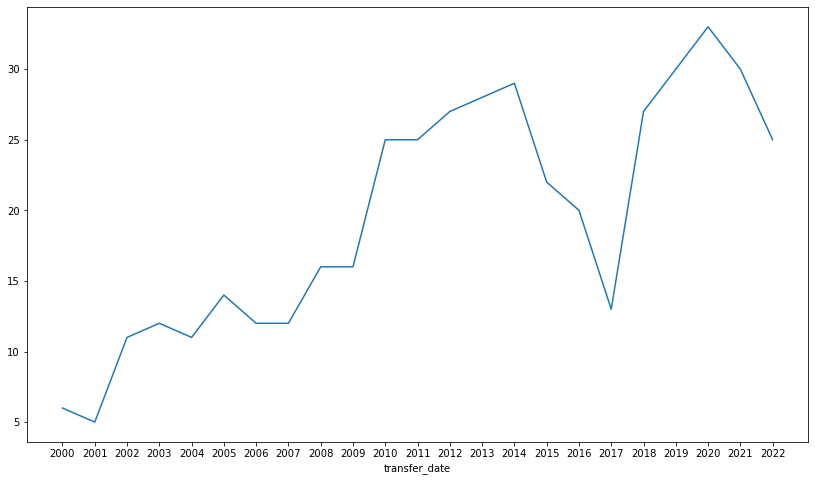

In [55]:
yearly_loans = intra_buli_transfers[intra_buli_transfers["transfer_type"] == 1].groupby(["transfer_date"])["player_name"].count()
yearly_loans.plot(figsize=(14,8), xticks=yearly_values_fees.index)

In [56]:
yearly_loans

transfer_date
2000     6
2001     5
2002    11
2003    12
2004    11
2005    14
2006    12
2007    12
2008    16
2009    16
2010    25
2011    25
2012    27
2013    28
2014    29
2015    22
2016    20
2017    13
2018    27
2019    30
2020    33
2021    30
2022    25
Name: player_name, dtype: int64

## Looking at the loans for 2018 in more detail, we can see 4 players with a value of more than 10 million Euros, 2 of which even have significantly higher values. 

In [57]:
intra_buli_transfers.loc[intra_buli_transfers["transfer_date"] == 2018].loc[intra_buli_transfers["transfer_type"] == 1].sort_values("player_value", ascending=False).head(10)

,club_from,club_to,player_age,player_name,player_nationality,player_position,player_value,transfer_date,transfer_fee,transfer_type
949,TSG 1899 Hoffenheim,FC Bayern München,22.0,Serge Gnabry,Deutschland,RA,55.0,2018,0.0,1.0
960,TSG 1899 Hoffenheim,FC Augsburg,21.0,Gregor Kobel,Schweiz,TW,35.0,2018,0.0,1.0
988,Fortuna Düsseldorf,Borussia Mönchengladbach,21.0,Florian Neuhaus,Deutschland,ZM,15.0,2018,0.0,1.0
958,TSG 1899 Hoffenheim,SC Freiburg,25.0,Vincenzo Grifo,Italien,LA,12.0,2018,0.0,1.0
987,Eintracht Frankfurt,Hannover 96,23.0,Marius Wolf,Deutschland,RV,9.0,2018,0.0,1.0
959,TSG 1899 Hoffenheim,Hannover 96,23.0,Kevin Akpoguma,Nigeria,IV,4.0,2018,0.0,1.0
966,VfB Stuttgart,Borussia Dortmund,19.0,Jacob Bruun Larsen,Dänemark,LA,4.0,2018,0.0,1.0
957,TSG 1899 Hoffenheim,VfB Stuttgart,27.0,Steven Zuber,Schweiz,LA,2.5,2018,0.0,1.0
970,Borussia Dortmund,Eintracht Frankfurt,28.0,Sebastian Rode,Deutschland,ZM,2.5,2018,0.0,1.0
994,1.FC Nürnberg,SV Werder Bremen,22.0,Ulisses Garcia,Schweiz,LV,2.0,2018,0.0,1.0


## If we look at fees and values of transfers excluding loans, the disconnect is still clearly visible but only becomes drastic after 2020, supporting my expectation of it being an effect of the Covid Pandemic in conjunction with high-value loans:

<AxesSubplot:xlabel='transfer_date'>

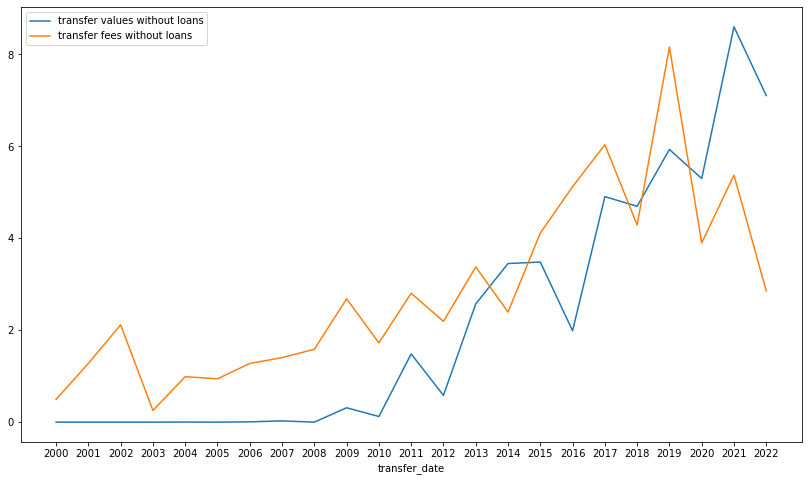

In [58]:
yearly_values_no_loans = intra_buli_transfers[intra_buli_transfers["transfer_type"] != 1].groupby(["transfer_date"])["player_value"].mean()
yearly_fees_no_loans = intra_buli_transfers[intra_buli_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].mean()

pd.DataFrame({"transfer values without loans": yearly_values_no_loans, 
              "transfer fees without loans": yearly_fees_no_loans}).plot(figsize=(14,8), xticks=yearly_values_fees.index)

## Looking at numbers of transfers vs. numbers of loans supports my expectations:

<AxesSubplot:xlabel='transfer_date'>

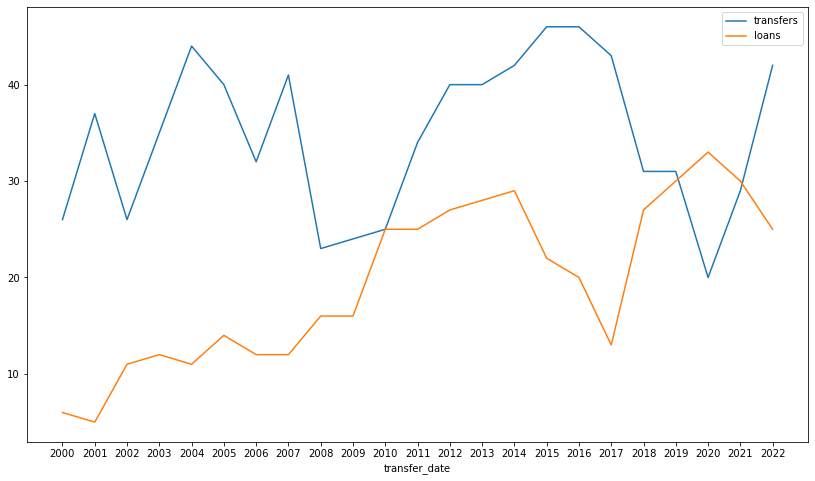

In [59]:
yearly_transfers_no_loan = intra_buli_transfers[intra_buli_transfers["transfer_type"] != 1].groupby(["transfer_date"])["player_name"].count()

transfers = pd.DataFrame({"transfers": yearly_transfers_no_loan, "loans": yearly_loans})
transfers.plot(figsize=(14,8), xticks=yearly_loans.index)


## Looking at the comparison of incoming and outgoing transfers with regards to their total and mean values shows, that fees for incoming transfers are consistently higher than those for outgoing transfers. This is more obvious for mean fees than for total values, as individual high-value transfers can contribute massively to the total fees.

<AxesSubplot:title={'center':'Mean transfer fees to and from Bundesliga clubs'}, xlabel='Year', ylabel='Mean transfer fee'>

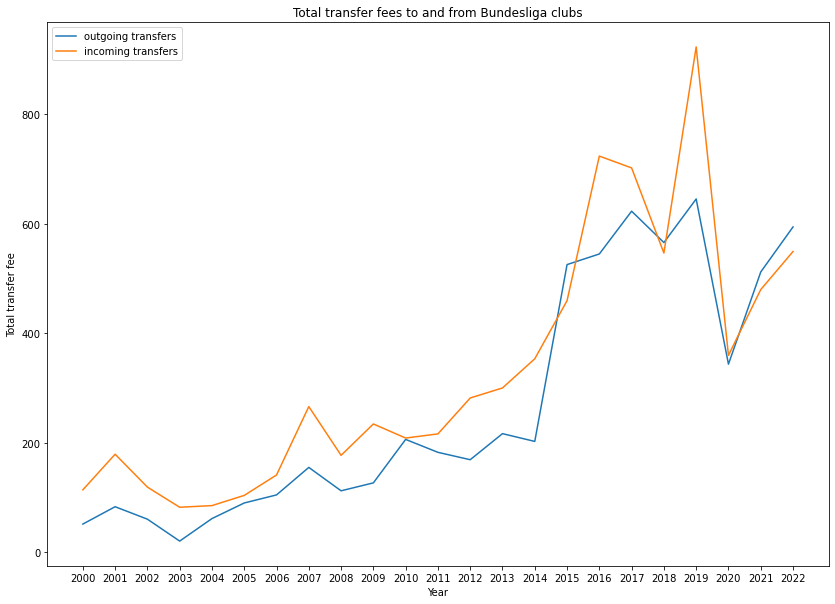

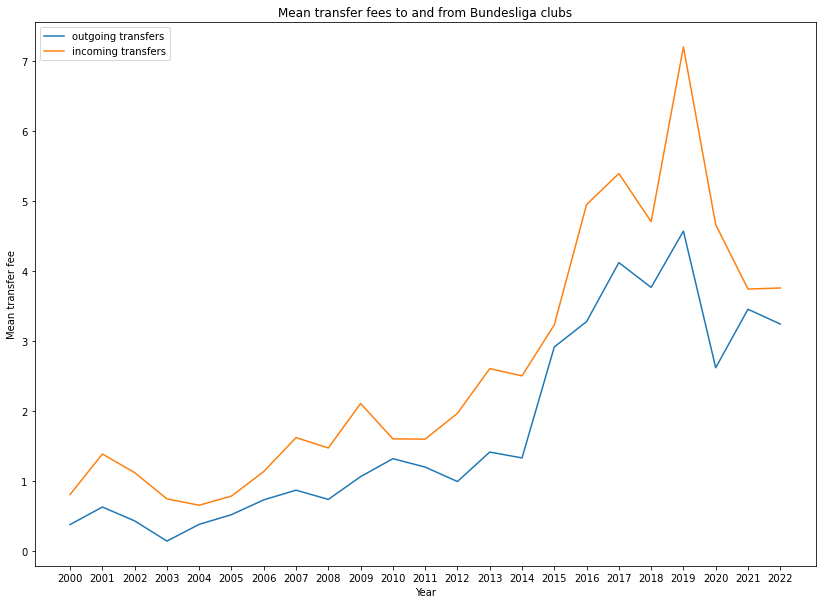

In [60]:
out_total_fee = outgoing_transfers.loc[outgoing_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].sum()
in_total_fee = incoming_transfers.loc[incoming_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].sum()

out_median_fee = outgoing_transfers.loc[outgoing_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].mean()
in_median_fee = incoming_transfers.loc[incoming_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].mean()

pd.DataFrame({"outgoing transfers": out_total_fee, "incoming transfers": in_total_fee}).plot(ylabel="Total transfer fee", xlabel="Year", figsize=(14,10),
                                                                         xticks=yearly_transfer_types.index, 
                                                                          title="Total transfer fees to and from Bundesliga clubs")


pd.DataFrame({"outgoing transfers": out_median_fee, "incoming transfers": in_median_fee}).plot(ylabel="Mean transfer fee", xlabel="Year", figsize=(14,10),
                                                                         xticks=yearly_transfer_types.index, 
                                                                          title="Mean transfer fees to and from Bundesliga clubs")



## The top 10 outgoing transfers for 2015 (the first year in the timeframe of total outgoing transfer fees being higher than total incoming transfer fees) make up 284 million Euros in fees out of a total 525,07 (54%),  leaving the rest of a total of 269 transfer's fees amounting to less than half of the total amount, whereas the top 10 incoming transfers make up 191,75 million Euros out of a total of 459,15 (42%).
Speaking from personal experience, the top values for outgoing transfer fees to top clubs from other leagues were significantly higher than the ones for incoming transfers, explaining why mean values for ountgoing transfers would be consistently lower than mean values for incoming transfers, while total outgoing fees are slightly above total incoming fees for some years.

In [61]:
outgoing_transfers.loc[outgoing_transfers.transfer_date == 2015].sort_values("transfer_fee", ascending=False).head(10)


,club_from,club_to,player_age,player_name,player_nationality,player_position,player_value,transfer_date,transfer_fee,transfer_type
3285,VfL Wolfsburg,Manchester City,24.0,Kevin De Bruyne,Belgien,OM,80.0,2015,76.0,0.0
3282,FC Schalke 04,VfL Wolfsburg,21.0,Julian Draxler,Deutschland,LA,8.0,2015,43.0,0.0
3371,TSG 1899 Hoffenheim,FC Liverpool,23.0,Roberto Firmino,Brasilien,MS,22.0,2015,41.0,0.0
3315,Bayer 04 Leverkusen,Tottenham Hotspur,23.0,Heung-min Son,Südkorea,LA,60.0,2015,30.0,0.0
3333,FC Augsburg,FC Chelsea,21.0,Abdul-Rahman Baba,Ghana,LV,1.8,2015,26.0,0.0
3286,VfL Wolfsburg,Inter Mailand,26.0,Ivan Perisic,Kroatien,LM,10.0,2015,19.0,0.0
3272,FC Bayern München,Inter Mailand,23.0,Xherdan Shaqiri,Schweiz,OM,4.0,2015,15.0,0.0
3283,Borussia Mönchengladbach,VfL Wolfsburg,27.0,Max Kruse,Deutschland,HS,0.9,2015,12.0,0.0
3359,Borussia Dortmund,FC Sevilla,25.0,Ciro Immobile,Italien,MS,18.0,2015,11.0,0.0
3316,Bayer 04 Leverkusen,Borussia Dortmund,28.0,Gonzalo Castro,Deutschland,ZM,0.0,2015,11.0,0.0


In [62]:
outgoing_transfers.loc[outgoing_transfers.transfer_date == 2015].player_name.count()

269

In [63]:
incoming_transfers.loc[incoming_transfers.transfer_date == 2015].sort_values("transfer_fee", ascending=False).head(10)


,club_from,club_to,player_age,player_name,player_nationality,player_position,player_value,transfer_date,transfer_fee,transfer_type
2873,FC Schalke 04,VfL Wolfsburg,21.0,Julian Draxler,Deutschland,LA,8.0,2015,43.00,0.0
2858,Juventus Turin,FC Bayern München,28.0,Arturo Vidal,Chile,ZM,1.7,2015,39.25,0.0
2859,Shakhtar Donetsk,FC Bayern München,24.0,Douglas Costa,Brasilien,RA,2.0,2015,30.00,0.0
2896,SC Internacional Porto Alegre,Bayer 04 Leverkusen,26.0,Charles Aránguiz,Chile,ZM,3.5,2015,13.00,0.0
2897,Manchester United,Bayer 04 Leverkusen,27.0,Chicharito,Mexiko,MS,2.0,2015,12.00,0.0
2874,Borussia Mönchengladbach,VfL Wolfsburg,27.0,Max Kruse,Deutschland,HS,0.9,2015,12.00,0.0
2912,Bayer 04 Leverkusen,Borussia Dortmund,28.0,Gonzalo Castro,Deutschland,ZM,0.0,2015,11.00,0.0
2898,Borussia Dortmund,Bayer 04 Leverkusen,24.0,Kevin Kampl,Slowenien,ZM,5.0,2015,11.00,0.0
2930,1.FSV Mainz 05,FC Schalke 04,21.0,Johannes Geis,Deutschland,DM,1.0,2015,10.50,0.0
2883,Bayer 04 Leverkusen,Borussia Mönchengladbach,22.0,Josip Drmic,Schweiz,MS,3.0,2015,10.00,0.0


In [64]:
incoming_transfers.loc[incoming_transfers.transfer_date == 2015, "transfer_fee"].sum()

459.15000000000003

In [65]:
incoming_transfers.loc[incoming_transfers.transfer_date == 2015].player_name.count()

239

## I expect this effect to become even more obvious when we exclude intra-Bundesliga transfers.

In [66]:
into_buli_transfers = pd.concat([incoming_transfers, intra_buli_transfers, intra_buli_transfers]).drop_duplicates(keep=False)
into_buli_transfers.describe()

,player_age,player_value,transfer_date,transfer_fee,transfer_type
count,3586.000000,3586.000000,3586.000000,3586.000000,3586.000000
mean,23.790853,2.421025,2012.156442,1.480016,0.788901
std,3.800504,8.168162,6.565053,4.328348,0.744519
min,16.000000,0.000000,2000.000000,0.000000,0.000000
25%,21.000000,0.000000,2007.000000,0.000000,0.000000
50%,23.000000,0.125000,2012.000000,0.000000,1.000000
75%,26.000000,1.200000,2018.000000,1.000000,1.000000
max,39.000000,170.000000,2022.000000,80.000000,2.000000


In [67]:
out_of_buli_transfers = pd.concat([outgoing_transfers, intra_buli_transfers, intra_buli_transfers]).drop_duplicates(keep=False)
out_of_buli_transfers.describe()

,player_age,player_value,transfer_date,transfer_fee,transfer_type
count,4253.00000,4253.000000,4253.000000,4253.000000,4253.000000
mean,25.40348,1.466092,2012.131437,0.916682,1.325888
std,4.73939,6.167744,6.527414,5.177877,1.017985
min,16.00000,0.000000,2000.000000,0.000000,0.000000
25%,21.00000,0.000000,2007.000000,0.000000,1.000000
50%,25.00000,0.000000,2012.000000,0.000000,1.000000
75%,29.00000,0.500000,2018.000000,0.000000,2.000000
max,41.00000,170.000000,2022.000000,140.000000,4.000000


<AxesSubplot:title={'center':'Mean transfer fees to and from Bundesliga clubs without intra Bundesliga transfers'}, xlabel='Year', ylabel='Mean transfer fee'>

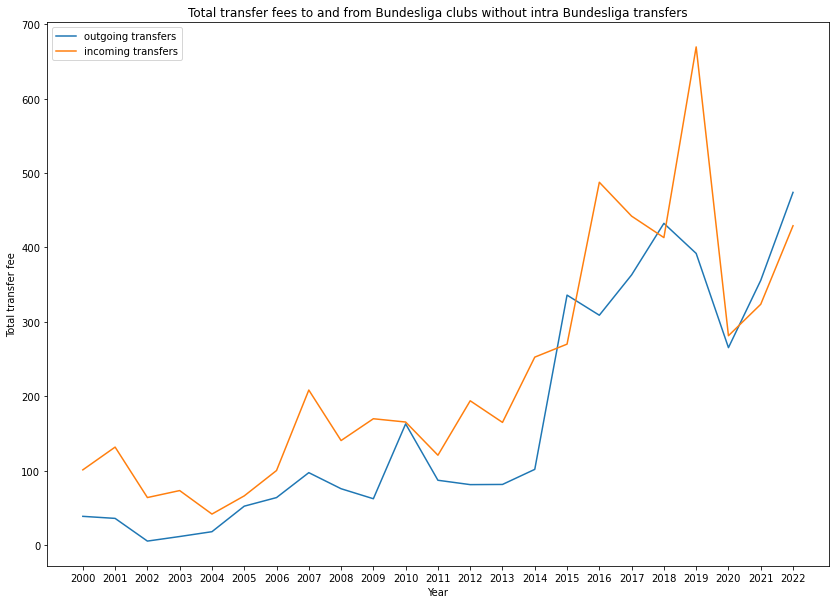

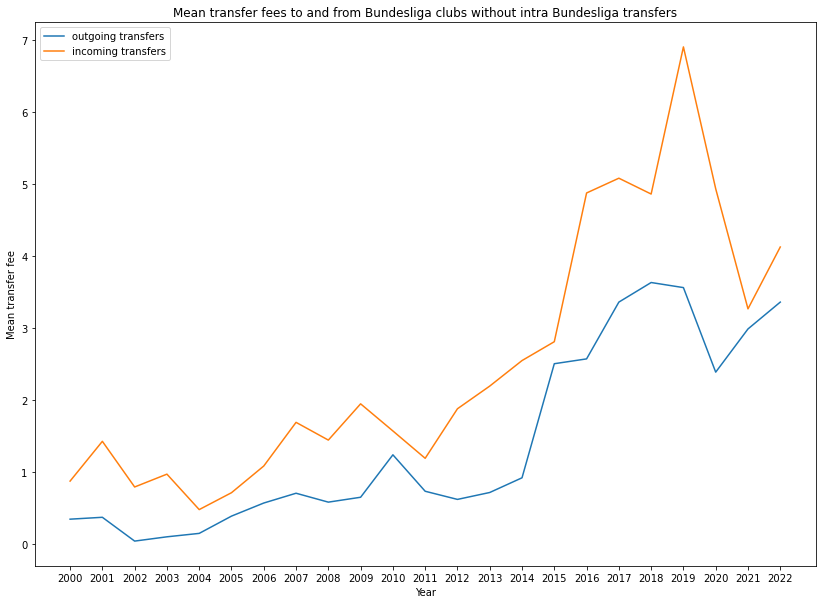

In [68]:
out_of_buli_total_fee = out_of_buli_transfers.loc[out_of_buli_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].sum()
into_buli_total_fee = into_buli_transfers.loc[into_buli_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].sum()

out_of_buli_median_fee = out_of_buli_transfers.loc[out_of_buli_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].mean()
into_buli_median_fee = into_buli_transfers.loc[into_buli_transfers["transfer_type"] != 1].groupby(["transfer_date"])["transfer_fee"].mean()


pd.DataFrame({"outgoing transfers": out_of_buli_total_fee, "incoming transfers": into_buli_total_fee}).plot(ylabel="Total transfer fee", xlabel="Year", figsize=(14,10),
                                                                         xticks=yearly_transfer_types.index, 
                                                                          title="Total transfer fees to and from Bundesliga clubs without intra Bundesliga transfers")


pd.DataFrame({"outgoing transfers": out_of_buli_median_fee, "incoming transfers": into_buli_median_fee}).plot(ylabel="Mean transfer fee", xlabel="Year", figsize=(14,10),
                                                                         xticks=yearly_transfer_types.index, 
                                                                          title="Mean transfer fees to and from Bundesliga clubs without intra Bundesliga transfers")



## As expected, the top ten outgoing transfers from Bundesliga clubs to non-Bundesliga clubs amount to 249,5 million Euros (74%), while the top ten incoming transfers from non-Bundesliga clubs to Bundesliga clubs amount to 137,25 million Euros (51%).

In [69]:
print(out_of_buli_transfers.loc[out_of_buli_transfers.transfer_date == 2015, "transfer_fee"].sum())
print(out_of_buli_transfers.loc[out_of_buli_transfers.transfer_date == 2015].player_name.count())
out_of_buli_transfers.loc[out_of_buli_transfers.transfer_date == 2015].sort_values("transfer_fee", ascending=False).head(10)

335.85
201


,club_from,club_to,player_age,player_name,player_nationality,player_position,player_value,transfer_date,transfer_fee,transfer_type
3285,VfL Wolfsburg,Manchester City,24.0,Kevin De Bruyne,Belgien,OM,80.00,2015,76.0,0.0
3371,TSG 1899 Hoffenheim,FC Liverpool,23.0,Roberto Firmino,Brasilien,MS,22.00,2015,41.0,0.0
3315,Bayer 04 Leverkusen,Tottenham Hotspur,23.0,Heung-min Son,Südkorea,LA,60.00,2015,30.0,0.0
3333,FC Augsburg,FC Chelsea,21.0,Abdul-Rahman Baba,Ghana,LV,1.80,2015,26.0,0.0
3286,VfL Wolfsburg,Inter Mailand,26.0,Ivan Perisic,Kroatien,LM,10.00,2015,19.0,0.0
3272,FC Bayern München,Inter Mailand,23.0,Xherdan Shaqiri,Schweiz,OM,4.00,2015,15.0,0.0
3359,Borussia Dortmund,FC Sevilla,25.0,Ciro Immobile,Italien,MS,18.00,2015,11.0,0.0
3287,VfL Wolfsburg,Norwich City,27.0,Timm Klose,Schweiz,IV,0.30,2015,11.0,0.0
3432,1.FSV Mainz 05,Leicester City,29.0,Shinji Okazaki,Japan,MS,0.25,2015,11.0,0.0
3403,Eintracht Frankfurt,FC Paris Saint-Germain,25.0,Kevin Trapp,Deutschland,TW,8.50,2015,9.5,0.0


In [83]:
print(into_buli_transfers.loc[into_buli_transfers.transfer_date == 2015, "transfer_fee"].sum())
print(into_buli_transfers.loc[into_buli_transfers.transfer_date == 2015].player_name.count())
into_buli_transfers.loc[into_buli_transfers.transfer_date == 2015].sort_values("transfer_fee", ascending=False).head(10)

269.93
171


,club_from,club_to,player_age,player_name,player_nationality,player_position,player_value,transfer_date,transfer_fee,transfer_type
2858,Juventus Turin,FC Bayern München,28.0,Arturo Vidal,Chile,ZM,1.7,2015,39.25,0.0
2859,Shakhtar Donetsk,FC Bayern München,24.0,Douglas Costa,Brasilien,RA,2.0,2015,30.00,0.0
2896,SC Internacional Porto Alegre,Bayer 04 Leverkusen,26.0,Charles Aránguiz,Chile,ZM,3.5,2015,13.00,0.0
2897,Manchester United,Bayer 04 Leverkusen,27.0,Chicharito,Mexiko,MS,2.0,2015,12.00,0.0
2931,Manchester City,FC Schalke 04,22.0,Matija Nastasić,Serbien,IV,1.5,2015,9.50,0.0
2885,FC Chelsea,Borussia Mönchengladbach,22.0,Thorgan Hazard,Belgien,LA,9.0,2015,8.00,0.0
2899,SC Freiburg,Bayer 04 Leverkusen,24.0,Admir Mehmedi,Schweiz,HS,0.5,2015,8.00,0.0
3077,Tottenham Hotspur,Hamburger SV,24.0,Lewis Holtby,Deutschland,ZM,0.5,2015,6.50,0.0
2952,SSC Neapel,TSG 1899 Hoffenheim,25.0,Eduardo Vargas,Chile,MS,1.8,2015,6.00,0.0
2933,1.FC Nürnberg,FC Schalke 04,21.0,Alessandro Schöpf,Österreich,RM,2.0,2015,5.00,0.0


<AxesSubplot:xlabel='player_position'>

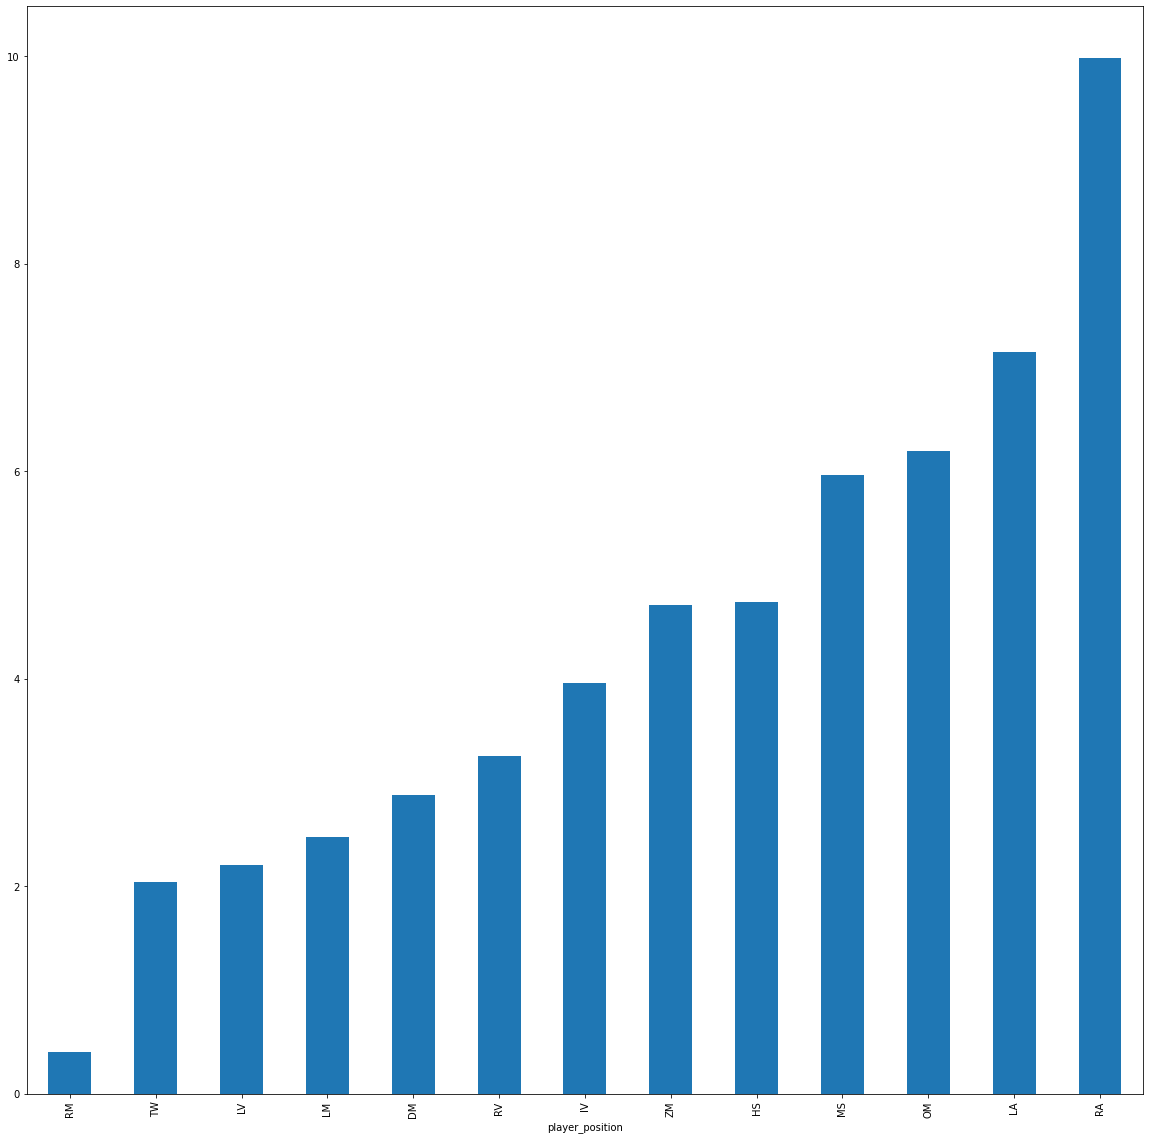

In [99]:
out_of_buli_transfers.loc[(out_of_buli_transfers.transfer_type != 1) & (out_of_buli_transfers.transfer_fee != 0)].groupby(out_of_buli_transfers.player_position).transfer_fee.mean().sort_values().plot(kind="bar", figsize=(20,20), x="player_position", y="transfer_fee")

In [82]:
out_of_buli_transfers.loc[(out_of_buli_transfers.transfer_type != 1) & (out_of_buli_transfers.transfer_fee != 0)].groupby(out_of_buli_transfers.transfer_fee).max()

,club_from,club_to,player_age,player_name,player_nationality,player_position,player_value,transfer_date,transfer_fee,transfer_type
transfer_fee,,,,,,,,,,
0.010,SV Werder Bremen,VfL Wolfsburg II,28.0,Michael Müller,Niederlande,TW,0.0,2011,0.010,0.0
0.013,SC Freiburg,SV Wacker Burghausen,25.0,Stefan Hampl,Deutschland,RA,0.0,2000,0.013,0.0
0.015,TSV 1860 München,1.FC Nürnberg,24.0,Rafael,Brasilien,IV,0.0,2003,0.015,0.0
0.025,VfL Bochum,MSV Duisburg,31.0,Steffen Haas,Deutschland,OM,0.0,2009,0.025,0.0
0.026,FC Energie Cottbus,FC Sachsen Leipzig (- 2011),25.0,Marco Eckstein,Deutschland,TW,0.0,2000,0.026,0.0
...,...,...,...,...,...,...,...,...,...,...
64.000,Borussia Dortmund,FC Chelsea,20.0,Christian Pulisic,Vereinigte Staaten,RA,32.0,2018,64.000,0.0
76.000,VfL Wolfsburg,Manchester City,24.0,Kevin De Bruyne,Belgien,OM,80.0,2015,76.000,0.0
80.000,Bayer 04 Leverkusen,FC Chelsea,21.0,Kai Havertz,Deutschland,OM,60.0,2020,80.000,0.0
